###### TASKS

AKHONA - 
INTERACTION BETWEEN BUSINESS AND PLARTFORM 
CORROLATION PLOTS
SCALING OF VARIABLES
OUTLIERS
CORRELATION / MULTICOLLINERITY
FEATURE SELECTON
ENSEMBLING - RF
COMPARE TRAIN  TEST PERFOMANCE

NDUDUZO
Check validity of target
Geospatial data
Advanced tree models
Gradient boosted machine

NOXOLO
Precipitation - rainfall
sklearn Pipeline
relationship between long, lat and destance

Kgomotso

# Introduction

## Context

Sendy, in partnership with insight2impact facility, is hosting a Zindi challenge to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

The solution will help Sendy enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

Sendy helps men and women behind every type of business to trade easily, deliver more competitively, and build extraordinary businesses.

## Problem Statement

Data is a critical component in helping Sendy to build more efficient, affordable and accessible solutions. Given the details of a Sendy order, can we use historic data to predict an accurate time for the arrival of the rider at the destination of a package? In this competition, we’re challenging you to build a model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

# Data Exploration

## Import packages and load data files

###### task: import and load data
We start off by importing relevant packages and loading the data.

In [77]:
# import packages

import pprint
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from datetime import datetime, date

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

pp = pprint.PrettyPrinter()

SyntaxError: invalid syntax (<ipython-input-77-671034b3b356>, line 2)

In [2]:
# load data
train_data = pd.read_csv('data/Train.csv')
test_data = pd.read_csv('data/Test.csv')
riders_data = pd.read_csv('data/Riders.csv')


###### task: display variable descriptions

Variable descriptions are stored in the csv Variable definations. Here we load that csv and print out each row. This is so we can come back and check what each variable in the dataset means later when we need to.

In [3]:
variable_defs = pd.read_csv('data/VariableDefinitions.csv')
variable_defs = variable_defs.drop_duplicates(subset = 'Order No').dropna(how = 'all')
variable_defs.set_index('Order No', inplace = True)
for feature in variable_defs.index:
    print('{}: '.format(feature), variable_defs.loc[feature, :][0])

User Id:  Unique number identifying the customer on a platform
Vehicle Type:  For this competition limited to bikes, however in practice Sendy service extends to trucks and vans
Platform Type:  Platform used to place the order, there are 4 types
Personal or Business:  Customer type
Placement - Day of Month:  Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1):  Placement - Weekday (Monday = 1)
Placement - Time:  Placement - Time - Time of day the order was placed
Confirmation - Day of Month:  Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1):  Confirmation - Weekday (Monday = 1)
Confirmation - Time:  Confirmation - Time - Time of day the order was confirmed by a rider
Arrival at Pickup - Day of Month:  Arrival at Pickup - Day of Month i.e 1-31
Arrival at Pickup - Weekday (Mo = 1):  Arrival at Pickup - Weekday (Monday = 1)
Arrival at Pickup - Time:  Time of day the the rider arrived at the location to pick up the order - as marked by the rider through the S

###### task: display the shape of train and test data
Train consists of 21201 orders and 29 features. Test_data consists of orders and 25 features. This makes sense as the train data should contain extra columns that are not available in the test data i.e the target. Lets do further investigation of this.

In [4]:
print('Train rows and columns :', train_data.shape)
print('Test rows and columns :', test_data.shape)

Train rows and columns : (21201, 29)
Test rows and columns : (7068, 25)


###### task: investigate the target. 
We find that really train_data has 4 extra columns that relate to the target. These are displayed in the output below and stored in a list object named target_vars

In [5]:
train_column_names = train_data.columns.values # get the train column names 
test_column_names = test_data.columns.values # het the test column names
target_vars = list(set(train_column_names) - set(test_column_names)) # the difference between train and test column names leaves the trget column names 
print('Target columns')
print(target_vars)

Target columns
['Arrival at Destination - Time', 'Time from Pickup to Arrival', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)']


###### task: Join the riders_data with both train and test data. 
We are also provided with a Riders csv file. Given that a single rider can make multiple deliveries we do not expect the length of this file to be the same as that of our training or testing datasets. Below we display the total number of riders (960). Of these 960, 924 have appearance in train_data while 822 make appearance in test_data. 952 make apperance in both train and test data, meaning 8 riders have not made any deliveries in the provided datasets.

In [6]:
print(' Total Riders :', riders_data['Rider Id'].nunique(), 
      '\n Riders in train data :',train_data['Rider Id'].nunique(),
      '\n Riders in test data :',test_data['Rider Id'].nunique(),
      '\n Intersection between train & test data :', pd.Series(test_data['Rider Id'].to_list() + train_data['Rider Id'].to_list()).nunique()
     )
rider_vars = riders_data.columns.to_list()
rider_vars

 Total Riders : 960 
 Riders in train data : 924 
 Riders in test data : 822 
 Intersection between train & test data : 952


['Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings']

Finally, when joining the datasets we prioritise observations in train and test datausing the how parameter of pd.merge.

In [7]:
train_data = pd.merge(
                left = train_data,
                right = riders_data,
                how = 'left'
            )

test_data = pd.merge(
                left = test_data,
                right = riders_data,
                how = 'left'
            )

###### task: head - train and test data
Simply displaying the train and test data.

In [8]:
# print train_data
train_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


In [9]:
# print test_data
test_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868,488,273,14.4,45
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26,833,460,13.1,67
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685,487,560,13.7,44
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858,4761,1120,14.1,1010


###### Conclude
In this section we have covered importing modules, loading the data, merging rider data with both train and test set. 
Note that the number of columns has increased by 4 in both train and test datasets. These are the 4 features that come with the riders_data i.e 
1. No_Of_Orders:   Number of Orders the rider has delivered
2. Age:  Number of days since the rider delivered the first order
3. Average_Rating:  Average rating of the rider
4. No_of_Ratings

We are now a little familiar with the data. Lets get more familiar with it by exploring the data structures associated with each of our feature columns.

## Data Structures

The importance of correctly encoding column datatypes cannot be overstated. This will become clear later when we do Exploratory Data Analysis and eventually when preprocessing data for machine learning. Numeric features should encoded as such and so are categorical features and date and time objects. This section is devoted to making ensure consistency in data types. We begin by checking the current datatype per column. If the datatypes are correct, we need to classify the column names either to numeric_vars for numeric columns or factor_vars for categorical columns.

###### task: write user functions to check as well as classify columns by datatype

In [10]:
# user function to check a pd.Series()'s datatype
def checkDataType(df, column_name):
    dtype = df[column_name].dtype
    return str(dtype)

# user function that classifies columns by datatype
def classifyColumnsByDataType(df):

    id_cols = ['Order No', 'User Id', 'Rider Id'] # not interested in classifying id columns
    
    numeric_type = ['int16', 'int64', 'float16', 'float64'] # these are classified as numeric varibles
    factor_type = ['object']                                # these are classified as categorical / factor type
    
    numeric_vars = list()                                   # empty container
    factor_vars = list()                                    # empty container

    for column_name in df.columns:
        data_type = checkDataType(df = df, column_name = column_name) # check data type

        if column_name not in id_cols + list(target_vars):            # classify accordingly
            if data_type in numeric_type:
                numeric_vars.append(column_name)
            else:
                factor_vars.append(column_name)
#             print('{}: '.format(column_name), checkDataType(df = train_data, column=column_name))
    return numeric_vars, factor_vars                  # return tuple of 2 (numeric and factors)

###### task: check and classify columns by datatype

In [11]:
numeric_vars, factor_vars = classifyColumnsByDataType(df = train_data) # apply function

print('Numeric Features:')
pp.pprint(numeric_vars)
print('')
print('Categorical/Factor Features:')
pp.pprint(factor_vars)

Numeric Features:
['Platform Type',
 'Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Confirmation - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Arrival at Pickup - Day of Month',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Pickup - Day of Month',
 'Pickup - Weekday (Mo = 1)',
 'Distance (KM)',
 'Temperature',
 'Precipitation in millimeters',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings']

Categorical/Factor Features:
['Vehicle Type',
 'Personal or Business',
 'Placement - Time',
 'Confirmation - Time',
 'Arrival at Pickup - Time',
 'Pickup - Time']


###### Motivation for classifying columns by type
The importance of creating vector objects that contain a group of column names belonging in each class will become apparent when we start analysing our data. For example, it will be easy to just apply a certain transformations to factor features by simply filtering our data. See following example where we simply display only a subset of the data. Now it becomes easy to notice inconsistencies in data types. Surely the time variable classified under factors do not belong here. In the upcoming section we create yet another list object that stores these feature names separately.

In [12]:
train_data.loc[:, factor_vars].head()

,Vehicle Type,Personal or Business,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time
0,Bike,Business,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM
1,Bike,Personal,11:16:16 AM,11:23:21 AM,11:40:22 AM,11:44:09 AM
2,Bike,Business,12:39:25 PM,12:42:44 PM,12:49:34 PM,12:53:03 PM
3,Bike,Business,9:25:34 AM,9:26:05 AM,9:37:56 AM,9:43:06 AM
4,Bike,Personal,9:55:18 AM,9:56:18 AM,10:03:53 AM,10:05:23 AM


Also, displaying numeric vars we see that there are weekday and month day columns we would like to store eparately from numeric_vars. We also have geospatial data, Longitude and Latitude variables we would like to store separately. Ofcoarse, for modelling purposes these will need to be numeric but for data analysis we would rather have them separately.

In [13]:
train_data.loc[:, numeric_vars].head()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,3,9,5,9,5,9,5,9,5,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549
1,3,12,5,12,5,12,5,12,5,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69
2,3,30,2,30,2,30,2,30,2,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,1023,242,12.5,114
3,3,15,5,15,5,15,5,15,5,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,886,283,14.5,113
4,1,13,1,13,1,13,1,13,1,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,2311,872,14.1,533


##### Time features

###### task: store time variables in a separate list object time_vars
Filtering train_data and displaying only the factor_vars, it is clear that ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time'] are not supposed to be encoded as factors. They should be encoded as time objects. Now we can apply a function to encode them as such. Looking at the output above, see the pattern. All features we want to transform have "Time" in their column name. Use string.find() method to identify them and store them separately. Also note that these columns are removed from factor_vars and appended to time_vars who serves exactly the same purpose as numeric_vars and factor_vars. The transformation will be done in a later section. For now we are just getting organised.


Being aware that "Time from Pickup to Arrival" as the target variable is already stored in target_vars we exclude the variable from this operation.

In [14]:
time_vars = list()
for column_name in train_data.columns:
    # find columns with string "Time"(exclude target)
    if column_name.find("Time") != -1 and column_name not in ['Time from Pickup to Arrival']: #except the target
        print('{} :'.format(column_name), 'Found')  # print () if found
        if column_name in factor_vars:
            # append to time_vars object
            time_vars.append(column_name)
            # remove from factor_vars
            factor_vars.remove(column_name)
train_data.loc[:, time_vars].head()

Placement - Time : Found
Confirmation - Time : Found
Arrival at Pickup - Time : Found
Pickup - Time : Found
Arrival at Destination - Time : Found


,Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time
0,9:35:46 AM,9:40:10 AM,10:04:47 AM,10:27:30 AM
1,11:16:16 AM,11:23:21 AM,11:40:22 AM,11:44:09 AM
2,12:39:25 PM,12:42:44 PM,12:49:34 PM,12:53:03 PM
3,9:25:34 AM,9:26:05 AM,9:37:56 AM,9:43:06 AM
4,9:55:18 AM,9:56:18 AM,10:03:53 AM,10:05:23 AM


###### task: store week and month day variables in separate list objects (month_day_vars & week_day_vars)
This we do for the same reasons as above.

In [15]:
month_day_vars = list()
week_day_vars = list()
for column_name in train_data.columns.to_list():
    if column_name.find("Month") != -1 and column_name not in target_vars: 
        print(column_name)
        month_day_vars.append(column_name)
        numeric_vars.remove(column_name)
    elif column_name.find("Week") != -1and column_name not in target_vars:
        print(column_name)
        week_day_vars.append(column_name)
        numeric_vars.remove(column_name)
train_data.loc[:, month_day_vars + week_day_vars].head()

Placement - Day of Month
Placement - Weekday (Mo = 1)
Confirmation - Day of Month
Confirmation - Weekday (Mo = 1)
Arrival at Pickup - Day of Month
Arrival at Pickup - Weekday (Mo = 1)
Pickup - Day of Month
Pickup - Weekday (Mo = 1)


,Placement - Day of Month,Confirmation - Day of Month,Arrival at Pickup - Day of Month,Pickup - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Weekday (Mo = 1),Arrival at Pickup - Weekday (Mo = 1),Pickup - Weekday (Mo = 1)
0,9,9,9,9,5,5,5,5
1,12,12,12,12,5,5,5,5
2,30,30,30,30,2,2,2,2
3,15,15,15,15,5,5,5,5
4,13,13,13,13,1,1,1,1


##### Geospatial data (Longitude and Latitude)
If you remember we from displaying the numeric subset of the data we saw some geospartial features. This is where we store them in a separate list object geospatial_vars. This is done for the same reasons as above.

###### task: create a vector to store column names for geospatial data

In [16]:
geospatial_vars = list()
for column_name in train_data.columns:
    if column_name.find("Lat") != -1 or column_name.find("Long") != -1: 
        geospatial_vars.append(column_name)
        numeric_vars.remove(column_name)
train_data.loc[:, geospatial_vars].head()

,Pickup Lat,Pickup Long,Destination Lat,Destination Long
0,-1.317755,36.830370,-1.300406,36.829741
1,-1.351453,36.899315,-1.295004,36.814358
2,-1.308284,36.843419,-1.300921,36.828195
3,-1.281301,36.832396,-1.257147,36.795063
4,-1.266597,36.792118,-1.295041,36.809817


##### Features with very few unique values
The operation we undertake here is meant to identify if there are any variables with very few unique values among the numeric variables. These may best be regarded as factors. The threshold value we use below in 5 such that if a column has less than 5 unique values it is automatical added to factor_vars and removed from numeric_vars. This is based on the assumption that such features are likely a factors - maybe ordinal factors. The experiment helped us identify "Platform Type".

###### task: find variables with very few unique values 

In [17]:
for column_name in train_data[numeric_vars].columns.to_list():
    levels = train_data[column_name].nunique()
    if levels < 5: 
        print(column_name)
        factor_vars.append(column_name)
        numeric_vars.remove(column_name)

Platform Type


###### task: finally encode factors as categoric python

In [18]:
# user function to encode factors
def convertToCategory(df, column_names):
    for column_name in column_names:
        df['{}'.format(column_name)] = pd.Categorical(df[column_name])
    return df

train_data = convertToCategory(train_data, factor_vars)
train_data.loc[:, factor_vars].head()

,Vehicle Type,Personal or Business,Platform Type
0,Bike,Business,3
1,Bike,Personal,3
2,Bike,Business,3
3,Bike,Business,3
4,Bike,Personal,1


##### Conclude
This has been a really insightful section. We have leant about our data structures and managed to get organised in hopes of making the data science process efficient in later chapters. However, looking at the table of numeric features above I saw some missing values for the column "Precipitation in millimetres". Is it possible that it is not the only column with such behaviour. The next section will be devoted to that investigation. Let's proceed. 

## Missing Values

Missing values are a common attribute in datasets and for a number of different reasons. In this part of the notebook we will do a minimal assessment of missing values. It is important however that we understand missingness from both the perspective of the train_data and test_data. As such we want to see which columns have missing data in both the train and test dataset as well as the proportion of missingness in each of those columns. The cell below does just that and displays a table as output. See below.

###### task: get the percentage of missing-ness in both train and test data

In [19]:
train_data.name = 'train_data'
test_data.name = 'test_data'

def findMissing(df):
    
    missing = df.isnull().sum()
    mask = missing > 0
    perc_missing = missing[mask].div(len(df)).mul(100).round(1)
    perc_missing = pd.DataFrame({'Percentage': perc_missing})
    perc_missing['data'] = df.name
    return perc_missing

perc_missing = pd.concat(
    [findMissing(train_data), findMissing(test_data)]
)
perc_missing

,Percentage,data
Temperature,20.6,train_data
Precipitation in millimeters,97.4,train_data
Temperature,20.3,test_data
Precipitation in millimeters,97.2,test_data


Looks like only 2 columns have missing data (Temperature and Precipitation in millimeters) in both train and test data and the distribution of missingness seems to be consistent in both datasets. This is fortunate for us as we wouldn't want a situation where for instance Temperature has low missingness in the train data of say 20% and high missingness of say 80% in the test data. The values indicate an almost identical distribution of missing values from the train to the test data. GOOD!. However, the missingness is high, particularly for the Precipitation variable (97.2%). We may have to exclude this feature from modelling. Temperature also has high missingness, about 20%. A later section under Exploratory Data Analysis will go into detail on how we treat these missing values. In the meantime we create yet another container list object that stores these 2 columns (missing_vars), serves the same purpose as numeric_vars, factor_vars etc.

###### task: store the feature names of the columns in a vector missing_vars

In [20]:
missingness_data = train_data.isnull().sum().div(len(train_data.index)).mul(100).round(2)
perc_missing = missingness_data[missingness_data > 0]
missings_vars = perc_missing.index.unique().to_list()
train_data.loc[:,missings_vars].head()

,Temperature,Precipitation in millimeters
0,20.4,NaN
1,26.4,NaN
2,NaN,NaN
3,19.2,NaN
4,15.4,NaN


###### task: visualise a binary indicator for the missingness of the Temperature column. Could it be useful?
Treating missing values by using a binary indicator (1 for missing and 0 otherwise) is a simply but common technique to assess whether missingness in meaningful or not. In this case, looking at the plot below for a binary indicator for Temperature I wouldn't say there is any information. If the distribution of the target "Time from Arrival to Pickup" was even slightly higher up in the scale then maybe we would have something. Either way we keep the new column. See plot below.

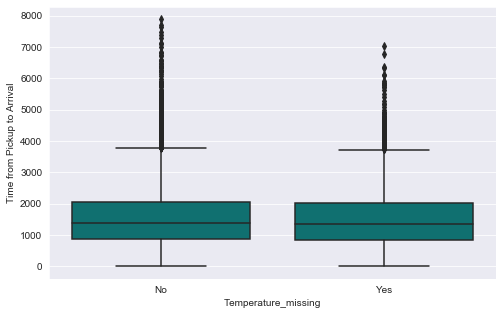

In [21]:
train_data['Temperature_missing'] = np.where(train_data['Temperature'].isnull(), 'Yes', 'No')
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_data, x='Temperature_missing', y='Time from Pickup to Arrival', color = 'teal')

###### Conclude
By now, we should be so much more familiar with the data. GOOD! Let's go a little further. Exploratory Data Analysis.

# Exploratory Data Analysis

##### Analysing the target variable
The target we attempt to predict in this challenge is the amount of time in seconds it takes a rider to go from pick to delivery of a package. The 3 plots on the left of the figure below we've generation a visual of the distribution of this dependent variable. It would seem the distribution is skewed to the right suggestin that there are riders who perhaps take a ridiculous amount of time to deliver someone's package. 8000 SECONDS! And by looking at the boxplot, clearly such values are outliers.The median rider takes about 1400 seconds to make a delivery. That's approximately 24 minutes, while there's a spike in the low end where riders take close to zero seconds to make a delivery. Maybe the party receiving is just next to the premises. We'll know soon enough. I think one of our variables measures the distance to location. 

Furthermore, the distribution barely conforms to normal standard. Look at the qqplot. A qqplot can be described as a visual diagnostic tool to check whether the distribution of a variable comforms to normality standards. On the x axis we would show theoretical quantiles of a distribution that meets the standard and on the y, we would show the quantiles of the distribution we are investigating. Inside the axis there would be a straight lines that represents a where a distribuion that conforms would lie. The task of the researcher would then be to visually assess by how much the sample distribution deviates from the straight line. That's exactly what we visualise in the lower grid of the plot. Clearly the target when raw fails that test. For this reason, we made an attempt to transform this variable. We applied a log transformation as well as a square root transformation. The characteristics are shown on the same figure. The intention was to try and get a distribution that closely resembles gaussians's distribution, as it conforms to normality standards. The transforms barely conform to that standard as well although the square root transformation offers the closest result.

In [22]:
###### task: write use function to generate multiple plots

# user function to generate multiple plots
def generateMultiPlot(df, variables, nrows, ncols, length, width, func):

    rows = range(0, nrows)
    columns = range(0, ncols)
    axis_position = list()

    for i,j in enumerate(rows):
        axis_position.append((i, j))

    for x in itertools.permutations(rows, len(columns)):
        axis_position.append(x[0:2])
    axis_position = pd.Series(axis_position).drop_duplicates().sort_values().to_list()

    var_axes = {variable: list(ax) for variable, ax in zip(variables, axis_position)}

    fig, axes = plt.subplots(nrows, ncols, figsize = (width, length))
    for variable, ax in var_axes.items():

        x = ax[1]
        y = ax[0]
        
        multiDist = func(
                      df[variable], 
                      color = "teal", 
                      ax = axes[x, y]
                    )
    return multiDist

###### task: apply transformations and visualise

In [23]:
target_raw = train_data.loc[:, 'Time from Pickup to Arrival'].copy()
mask = target_raw > 60 * 0
target_raw = target_raw[mask]
target_log_transformed = np.log(target_raw)
target_sq_transformed = np.sqrt(target_raw)

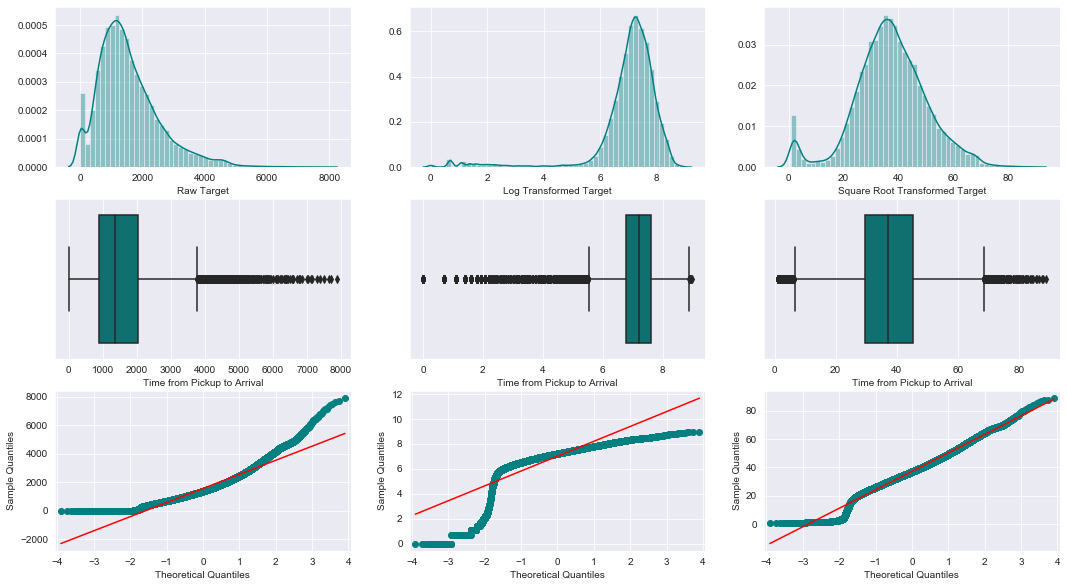

In [24]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 10))

dist = sns.distplot(target_raw, color = "teal", ax = ax[0, 0], axlabel = 'Raw Target')
box = sns.boxplot(target_raw, color = "teal", ax = ax[1, 0], orient='h')
qq = sm.qqplot(target_raw, line = 's', color = 'teal', ax = ax[2, 0])

dist = sns.distplot(target_log_transformed, color = "teal", ax = ax[0, 1], axlabel = 'Log Transformed Target')
box = sns.boxplot(target_log_transformed, color = "teal", ax = ax[1, 1], orient='h')
qq = sm.qqplot(target_log_transformed, line = 's', color = 'teal', ax = ax[2, 1])

dist = sns.distplot(target_sq_transformed, color = "teal", ax = ax[0, 2], axlabel = 'Square Root Transformed Target')
box = sns.boxplot(target_sq_transformed, color = "teal", ax = ax[1, 2], orient='h')
qq = sm.qqplot(target_sq_transformed, line = 's', color = 'teal', ax = ax[2, 2])

Visual inspection may lead us to a certain conclusion, and lead another researcher to a different one. Lets attempt to quantify these findings. The reason it is important to carry out this investigation can be illustrated by a final visual inspection. Look at the qqplot for the raw target for example, the slightly apparent U-shape is the result of riders who make their delivery in 6000 - 8000 seconds. The plot says that such values occur way too frequently is the sample that a normal distribution would infer. On the lower end, the skew is simply because riders generally dont ride for less than 0 seconds. This characteristic is clearly improved by the log transformation. But does it improve the perfomance of the models we will build. Its time to find out. We do this by fitting a model on the raw target, on the log transformed target and on the square transformed target. The target we will use from now one is one that gives better perfomance in the models we implement in the next section.

##### Benchmark Model

In this section we will fit a benchmark model and evaluate its perfomance on the three target variables as discussed above. The purpose of this model is not to be highly accurate at predicting delevery time, but to serve as a benchmark on which future models can be evaluated against. Therefore the amount of preprocessing done here is only minimal, just enough for the data to be consumed by a machine learning model like linear regression. Categoricals will be dummy encoded, features with missing values will be excluded but we include their binary indicator when relevant, timestamps will not be included but weekday and month day vars will be included. The following task does just that.

###### task: minimal data preprocessing

In [25]:
# select the above mentioned groups of predictors
predictors = list(set(numeric_vars + geospatial_vars + month_day_vars + week_day_vars + factor_vars + ['Temperature_missing']) - set(missings_vars))
X = train_data.loc[:, predictors]
X.head()

,Pickup - Weekday (Mo = 1),Destination Lat,Placement - Day of Month,Vehicle Type,Destination Long,Average_Rating,Age,Platform Type,Pickup - Day of Month,Temperature_missing,...,Distance (KM),No_of_Ratings,Confirmation - Weekday (Mo = 1),Personal or Business,Arrival at Pickup - Day of Month,Pickup Lat,Confirmation - Day of Month,Placement - Weekday (Mo = 1),Pickup Long,Arrival at Pickup - Weekday (Mo = 1)
0,5,-1.300406,9,Bike,36.829741,13.8,1309,3,9,No,...,4,549,5,Business,9,-1.317755,9,5,36.830370,5
1,5,-1.295004,12,Bike,36.814358,13.6,339,3,12,No,...,16,69,5,Personal,12,-1.351453,12,5,36.899315,5
2,2,-1.300921,30,Bike,36.828195,12.5,242,3,30,Yes,...,3,114,2,Business,30,-1.308284,30,2,36.843419,2
3,5,-1.257147,15,Bike,36.795063,14.5,283,3,15,No,...,9,113,5,Business,15,-1.281301,15,5,36.832396,5
4,1,-1.295041,13,Bike,36.809817,14.1,872,1,13,No,...,9,533,1,Personal,13,-1.266597,13,1,36.792118,1


In [26]:
# get dummy variable for all variables relevant. drop_first=True to avoid the dummy variable trap
X = pd.get_dummies(X, drop_first=True)
X.head()

,Pickup - Weekday (Mo = 1),Destination Lat,Placement - Day of Month,Destination Long,Average_Rating,Age,Pickup - Day of Month,No_Of_Orders,Distance (KM),No_of_Ratings,...,Pickup Lat,Confirmation - Day of Month,Placement - Weekday (Mo = 1),Pickup Long,Arrival at Pickup - Weekday (Mo = 1),Platform Type_2,Platform Type_3,Platform Type_4,Temperature_missing_Yes,Personal or Business_Personal
0,5,-1.300406,9,36.829741,13.8,1309,9,1637,4,549,...,-1.317755,9,5,36.830370,5,0,1,0,0,0
1,5,-1.295004,12,36.814358,13.6,339,12,396,16,69,...,-1.351453,12,5,36.899315,5,0,1,0,0,1
2,2,-1.300921,30,36.828195,12.5,242,30,1023,3,114,...,-1.308284,30,2,36.843419,2,0,1,0,1,0
3,5,-1.257147,15,36.795063,14.5,283,15,886,9,113,...,-1.281301,15,5,36.832396,5,0,1,0,0,0
4,1,-1.295041,13,36.809817,14.1,872,13,2311,9,533,...,-1.266597,13,1,36.792118,1,0,0,0,0,1


###### task: fit linear regression and cross validate performance
As mentioned a linear regression model will be fit to the data. To evaluate the model perfomance we obtain cross validate scores of the root mean squared erro metric. cv=10 means that the model will be train on 90% of the data and trained on the remaining 10% and this precess will repeat 10 times. Each sample goes in the test set only once but can be used for training more than once. Note that by the end of the process all data has been used atleast once for training and atleast once for testing. Generating perfomance scores this way has certain advantages. One of them relates to the 'variance' aspect of the bias variance trade-off. Obtaining multiple perfomance scores for a model and taking their average through a method such as K Fold cross validation results in a true and unbiased estimate of model perfomance. For wxample the 10 model tested in a 10 fold CV have varying perfomance statistics, some are high some low, and therefore taking the average accounts for such variation. Having 10 scores also allows one to get a sense of the models variation by computing the variance of those scores. It is for this reason that we use CV here. 
The linear regression method we implement come with the scikitlearn API in a class LinearRegression under the linear_model module. See import in the following code cell. We also import from sklearn.compose another class TransformedTargetRegressor. This we use to transform the target as explained above. Finally we import cross_val_score from sklearn.model_selection to implement cross validation.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import SCORERS

In [28]:
## data
X_train = X
y_train = target_raw

## define function to reverse square transformation
def Squared(x):
    return x ** 2
## Instantiating regressors
regressor = LinearRegression()
regressor1 = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log, inverse_func=np.exp)
regressor2 = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.sqrt, inverse_func=Squared)

## dictionary to loop 
my_dict = {
    'Raw Target': regressor,
    'Log Transformed Target': regressor1,
    'Square Root Transformed Target': regressor2
}

scores = {}   ## container for returned scores forr the 3 different models
for target, model in my_dict.items():
    errors = cross_val_score(estimator=model,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='neg_root_mean_squared_error') ## negative for API design consistents
    errors = np.array([abs(value) for value in errors]) ## get ubsolute value of the scores
    scores[target] = pd.Series(errors)

The code block below shows the average value of the scores. Root mean squared error is a common metric in the evaluation of regression models. It works by computing the differences between the actual and the predicted target values. Note that the difference is sometimes negative, when prediction fall short of the actual values, so this value needs to be squared, to avoid a zero sum, the squares are summed, and then its divided by the number of samples (n) for the average squared error and finally the square root is applied to bring it back to normal scale, thus the name "root_mean_squared_error". Generally we want this value to be as low as possible. Note that besides the quality of the distribution the raw target provides us the best score, followed by the square transformation. The values can be interpreted as follows, if for exaple I make the prediction the delivery time will be 1000 seconds for an order, then my erro range would be 203 secs on the lower bound and 1797 sec on the upper bound. But clearly this is of limeted use to someone who's not familiar with the entire range of the target. If the target's range is 0 to 100000 this surely is a small error but if it 0 to 2000, my model would be bad.

In [29]:
pd.DataFrame(scores).mean()

Raw Target                         797.255624
Log Transformed Target            1037.013630
Square Root Transformed Target     820.029917
dtype: float64

A popular variation or extension of the RMSE, one that I prefer to use because it is readily interpretable is the error rate. This metric expresses the root mean square error as a proportion of the average value of the actual target. So the code below takes rmse and simply divides that by the average of Time for Pickup To Arrival and finally multiplies by 100 to get the percentage. This is intepreted as follows, for the same example as above, my prediction wound have an error range of 51%. And this is regardless of the range of the target. So from now on we use this metric. We produce the rmse for a reader who prefers it though.

In [30]:
(pd.DataFrame(scores).mean() / np.mean(target_raw)) * 100

Raw Target                        51.207200
Log Transformed Target            66.606698
Square Root Transformed Target    52.669978
dtype: float64

The final step of our model evaluation is to get a sense of what features resulted in the best perfoming model. Since we are analysing a linear model we use the p_value to measure importance. Linear regression is a parameterised model, which means during the training process each variable is assigned a parameter that is leant by the model from the data. Think of the p_value as the probability of observing that parameter if the variable it has been assigned to was not predictive of the target. Surely we want the p_value to be small 9if we want the variable to be predictive). We use sklearn.feature_selection and import the f-regression class. This class produces two values for each feature included in a linear regression model i.e an F-score and a p_value. Our interest is in the p_value.See the code below.

In [31]:
from sklearn.feature_selection import f_regression
f_score, p_value = f_regression(X_train, y_train)

Also, since we are interested in variable importance, sounds not so intuitive to have an importance score that goes down with importance, so here I calculate a reverse score, just call it importance which is 1 - p_value, so that the importance of variables increases with importance rather that decrease with importance. Finally I save the results in a dataframe results and plot importance scores.

In [32]:
results = pd.DataFrame({
    'feature':X_train.columns,
    'f_score': f_score,
    'Importance': 1 - p_value
}
)
results = results.sort_values('Importance', ascending = False).set_index('feature').dropna()

In [33]:
results.head()

,f_score,Importance
feature,,
Destination Long,105.664496,1.0
Distance (KM),10780.448838,1.0
Pickup Long,77.324118,1.0
Destination Lat,81.465881,1.0
Pickup Lat,61.590505,1.0


Text(0, 0.5, ' ')

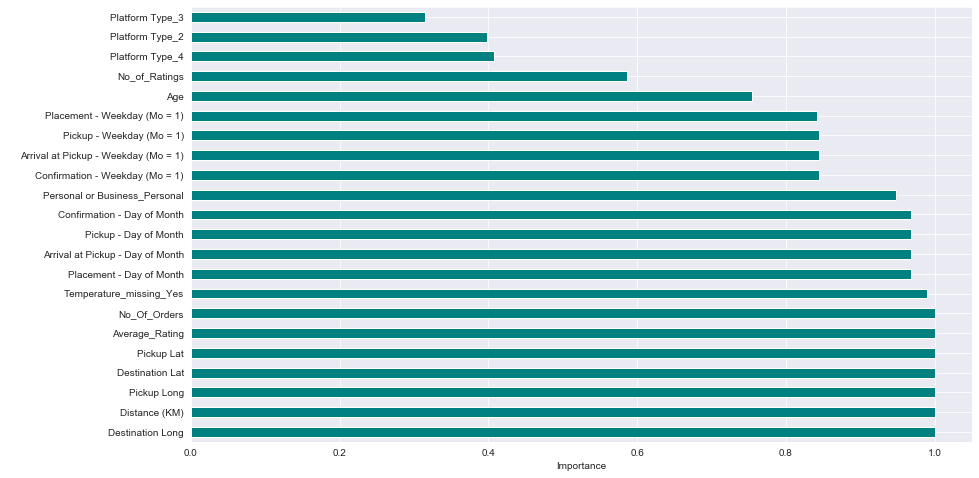

In [34]:
fig = plt.figure(figsize =(14, 8))
results['Importance'].plot(kind = 'barh', color = 'teal')
plt.xlabel('Importance')
plt.ylabel(' ')

I wouldn't say I am surprised that Distance has such a high score. I'm surprised by latitude and longitude variables. We also have some rider metrics like Numbuer of orders delivered since the first, average rating etc. Look also the temperature missing dummy, totally significant. Day of month variable also significant, at atleast 5% significance (p_value < 0.05). Weekday_vars perform poorly. Plartform type!

###### Conclude

EDA is getting fired up in the next section. Our benchmark model! I would say Sendy is better of making a guess about arrival times to destination. The error rate of the best performer is 51%. We also leant that the target is better represented raw as it is, despite the skewness, so we will continue to use it as such. We further leant from p_values that we should lookout for the Distance variable as well as geospatial data, they perform really well on this problem. Wea also learnt that representing missing temperatures with a binary encoder results in a well significant binary. The reason for this is not clear so far in the analysis. Thats what the next section is all about. EDA will help us uncover such phenomenon and the why? of this dataset. Shall we proceed.

## Numeric variables

###### task: plot numeric features
What better way to learn more about a dataset than by actually viualising it. Here we visualise numeric features. We lookout for the following:
1. outliers - these are values that lie too far are away from the rest of the other values in the vector of the target (the variable we attempt to predict)
2. leverage points - same as outliers except that this time we refer to predictor features.

The motivation for investigating and treating these values is as follows: outlier values and/or leverage points in data distributions sometimes have an impact in the pattern that is learnt by the models we build later. The term high leverage refers to the tendency of such values to affect the fit of the line, particularly in parameterised models like linear regression. As such, treating them accordingly allows such models to learn the underlying trend/distribution of the data, rather than one time instances that may never again occur in the data and at times these values are the result of data collection errors. The code cel below displays histograms for all numeric features.

In [35]:
# summary statistic
train_data.loc[:, numeric_vars].describe()

,Distance (KM),Temperature,Precipitation in millimeters,No_Of_Orders,Age,Average_Rating,No_of_Ratings
count,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,9.506533,23.258889,7.905797,1692.423706,984.742842,13.882520,341.067119
std,5.668963,3.615768,17.089971,1574.308302,646.652835,0.916071,402.867746
min,1.000000,11.200000,0.100000,2.000000,96.000000,0.000000,0.000000
25%,5.000000,20.600000,1.075000,557.000000,495.000000,13.600000,61.000000
50%,8.000000,23.500000,2.900000,1212.000000,872.000000,14.000000,161.000000
75%,13.000000,26.000000,4.900000,2311.000000,1236.000000,14.300000,495.000000
max,49.000000,32.100000,99.100000,9756.000000,3764.000000,15.200000,2298.000000


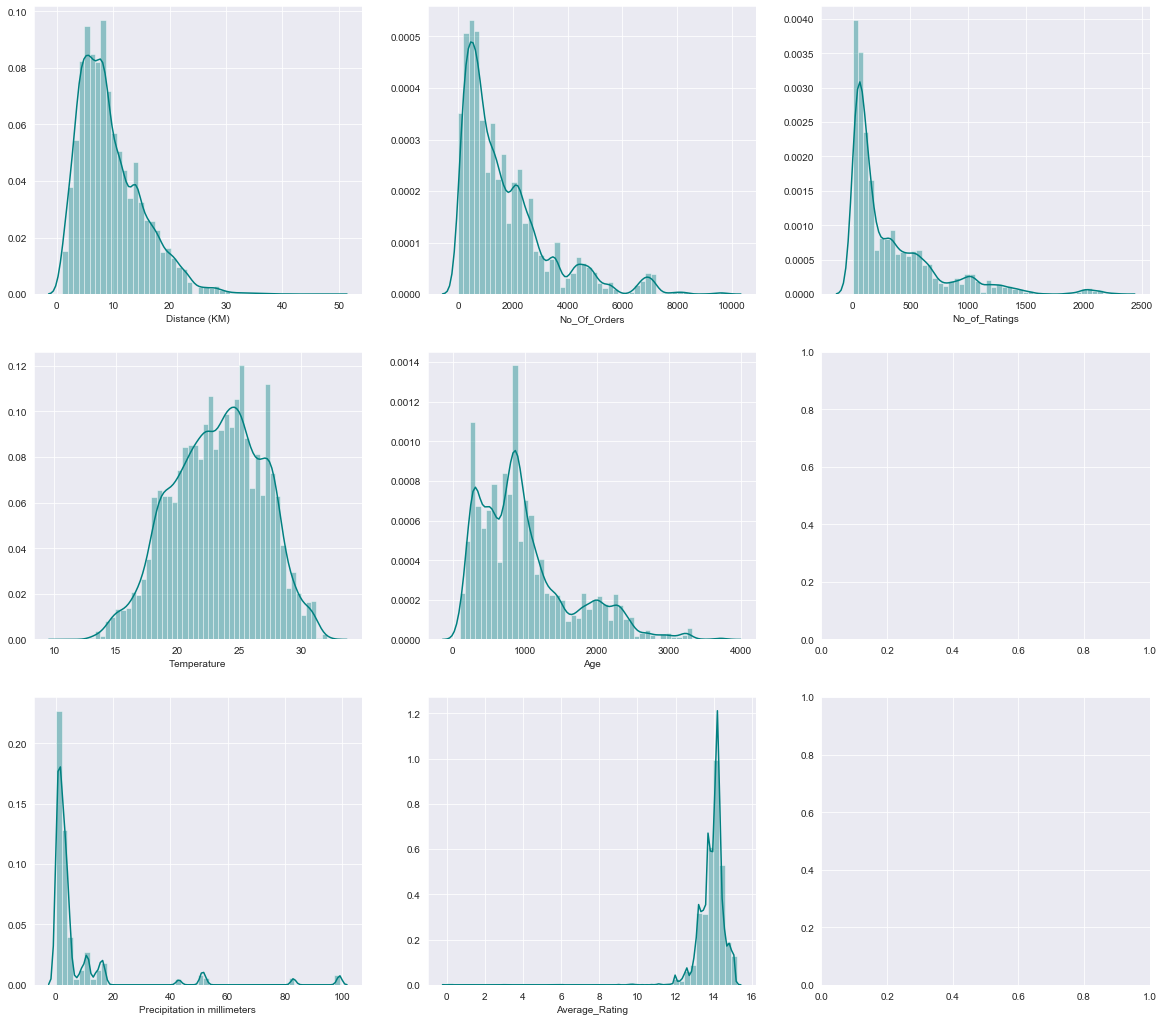

In [36]:
# generate histograms for numeric features
generateMultiPlot(
    df = train_data,
    variables = numeric_vars,
    nrows = 3,
    ncols = 3,
    length = 18,
    width = 20,
    func = sns.distplot
)

In [37]:
def plotDistScatter(feature):
    fig, axes = plt.subplots(1, 2, figsize = (12, 7))
    fig = sns.distplot(train_data[feature], ax = axes[0])
    fig = sns.scatterplot(data = train_data, x = feature, y = 'Time from Pickup to Arrival', ax = axes[1])
    return fig

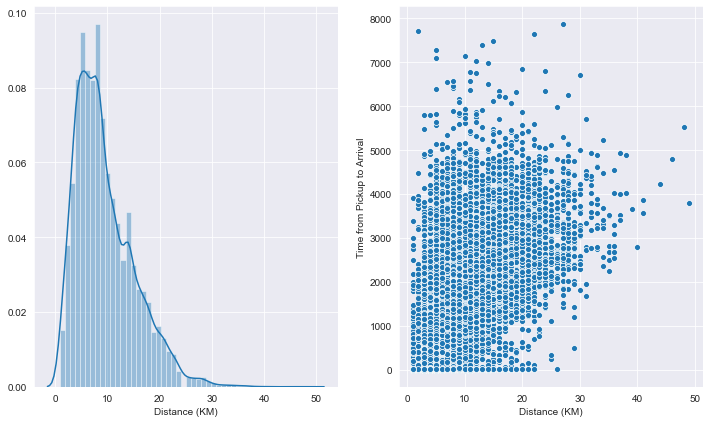

In [38]:
plotDistScatter('Distance (KM)')

In [39]:
rider_vars

['Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings']

In [40]:
pick_up_to_arr_minutes = train_data['Time from Pickup to Arrival'].div(60)
train_data['Speed_per_minute'] = train_data['Distance (KM)'].div(pick_up_to_arr_minutes)
speed_summary_stats = train_data['Speed_per_minute'].describe()
speed_summary_stats

count    21201.000000
mean         4.155090
std         31.754955
min          0.015337
25%          0.274390
50%          0.384410
75%          0.504808
max       1020.000000
Name: Speed_per_minute, dtype: float64

In [41]:
def findBounds(summary_stats):
    upper_bound = summary_stats['std'] * 2.5
    lower_bound = summary_stats['std'] * -2.5
    return lower_bound, upper_bound

In [42]:
lower, upper = findBounds(speed_summary_stats)
lower, upper

(-79.38738778315124, 79.38738778315124)

In [43]:
fast_riders = train_data[train_data['Speed_per_minute'] > upper]['Rider Id'].unique()
fast_riders[:5]

array(['Rider_Id_619', 'Rider_Id_652', 'Rider_Id_953', 'Rider_Id_10',
       'Rider_Id_647'], dtype=object)

In [44]:
i = 15
ith_percentile_lower_bound = np.percentile(train_data['Speed_per_minute'], i)
ith_percentile_lower_bound

0.21911138161898966

In [45]:
slow_riders = train_data[train_data['Speed_per_minute'] < ith_percentile_lower_bound]['Rider Id'].unique()
slow_riders[:5]

array(['Rider_Id_124', 'Rider_Id_114', 'Rider_Id_394', 'Rider_Id_607',
       'Rider_Id_436'], dtype=object)

In [46]:
def riderChar(x):
    if x in fast_riders:
        value = 'fast'
    elif x in slow_riders:
        value = 'slow'
    else:
        value = 'reasonable'
    return value

train_data['rider_speed'] = train_data['Rider Id'].map(riderChar)

<Figure size 1008x576 with 0 Axes>

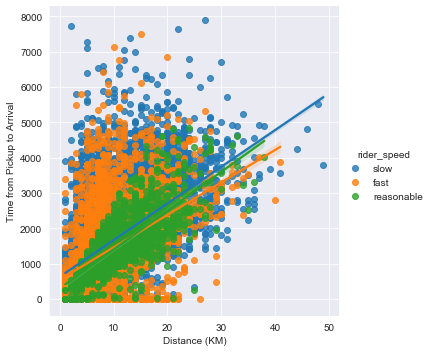

In [47]:
fig = plt.figure(figsize = (14, 8))
sns.lmplot(data = train_data, x = 'Distance (KM)', y = 'Time from Pickup to Arrival', hue = 'rider_speed')

In [48]:
rider_avg_speed = train_data.groupby('Rider Id')['Speed_per_minute'].mean()

rider_speed_data = pd.DataFrame(rider_avg_speed).reset_index().rename({'Speed_per_minute':'rider_avg_speed_per_minute'})
rider_speed_data.rename(columns = {'Speed_per_minute':'rider_avg_speed_per_minute'}, inplace = True
)
avg_speed_summary_stats = rider_speed_data['rider_avg_speed_per_minute'].describe()
avg_speed_summary_stats 

count    924.000000
mean       3.422313
std       12.797333
min        0.063091
25%        0.332414
50%        0.412914
75%        0.796303
max      151.676281
Name: rider_avg_speed_per_minute, dtype: float64

In [49]:
train_data = pd.merge(
    left = train_data,
    right = rider_speed_data,
    how='left',
    on = 'Rider Id'
)
train_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Temperature_missing,Speed_per_minute,rider_speed,rider_avg_speed_per_minute
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,Rider_Id_432,745,1637,1309,13.8,549,No,0.322148,slow,0.316656
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,Rider_Id_856,1993,396,339,13.6,69,No,0.481686,fast,15.119684
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,Rider_Id_155,455,1023,242,12.5,114,Yes,0.395604,slow,0.289148
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,Rider_Id_855,1341,886,283,14.5,113,No,0.402685,fast,16.953000
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,Rider_Id_770,1214,2311,872,14.1,533,No,0.444811,slow,0.385040


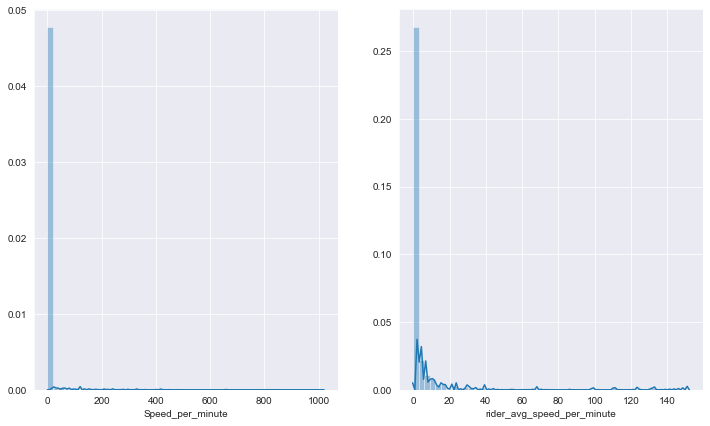

In [50]:
fig, axes = plt.subplots(1, 2, figsize = (12, 7))
sns.distplot(train_data['Speed_per_minute'], ax = axes[0])
sns.distplot(train_data['rider_avg_speed_per_minute'], ax = axes[1])

In [51]:
lower, upper = findBounds(avg_speed_summary_stats)
lower, upper

(-31.993333541454344, 31.993333541454344)

In [52]:
high_avg_speed_riders = train_data[train_data['rider_avg_speed_per_minute'] > upper]['Rider Id'].unique()
high_avg_speed_riders[:5]

array(['Rider_Id_619', 'Rider_Id_39', 'Rider_Id_239', 'Rider_Id_613',
       'Rider_Id_193'], dtype=object)

In [53]:
i = 15
ith_percentile_lower_bound = np.percentile(train_data['rider_avg_speed_per_minute'], i)
low_avg_speed_riders = train_data[train_data['rider_avg_speed_per_minute'] < ith_percentile_lower_bound]['Rider Id'].unique()
low_avg_speed_riders[:5]

array(['Rider_Id_432', 'Rider_Id_155', 'Rider_Id_394', 'Rider_Id_868',
       'Rider_Id_447'], dtype=object)

In [54]:
def riderChar(x):
    if x in high_avg_speed_riders:
        value = 'fast'
    elif x in low_avg_speed_riders:
        value = 'slow'
    else:
        value = 'reasonable'
    return value

train_data['rider_avg_speed'] = train_data['Rider Id'].map(riderChar)

<Figure size 1008x576 with 0 Axes>

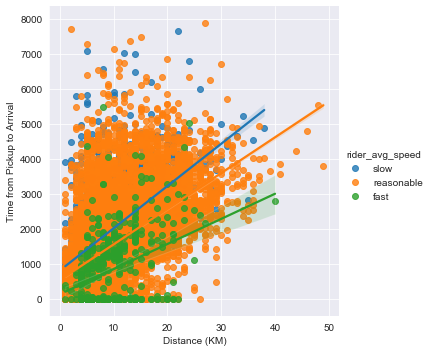

In [55]:
fig = plt.figure(figsize = (14, 8))
sns.lmplot(data = train_data, x = 'Distance (KM)', y = 'Time from Pickup to Arrival', hue = 'rider_avg_speed')

In [56]:
rider_speed_stds = train_data.groupby('Rider Id')[['Speed_per_minute']].std().reset_index()
rider_speed_stds.rename(columns = {'Speed_per_minute':'speed_std'}, inplace = True)
rider_speed_stds.fillna(rider_speed_stds.mean(), inplace = True) # riders with na std

In [57]:
train_data = pd.merge(
    left = train_data,
    right = rider_speed_stds,
    how = 'left'
)
train_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Temperature_missing,Speed_per_minute,rider_speed,rider_avg_speed_per_minute,rider_avg_speed,speed_std
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,1637,1309,13.8,549,No,0.322148,slow,0.316656,slow,0.126703
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,396,339,13.6,69,No,0.481686,fast,15.119684,reasonable,98.318060
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1023,242,12.5,114,Yes,0.395604,slow,0.289148,slow,0.125526
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,886,283,14.5,113,No,0.402685,fast,16.953000,reasonable,63.707631
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,2311,872,14.1,533,No,0.444811,slow,0.385040,reasonable,0.130518


In [58]:
def isExceedinglyFast(x, y, deviations):
    return x > y * deviations

def isExceedinglySlow(x, y, deviations):
    return x < y * -deviations

riders = train_data['Rider Id'].unique()

riders_list = list()
error_rides_list = list()
for rider in riders:
    data = train_data[train_data['Rider Id'] == rider]
    x = data['Speed_per_minute']
    y = data['speed_std']

    number_of_errors = (isExceedinglyFast(x, y, 2)).sum() ### | isExceedinglySlow(x, y, 2)
    percentage_error = ((number_of_errors / len(x)) * 100).round(2)
    error_rides_list.append(percentage_error)
    riders_list.append(rider)

In [59]:
error_rides_data = pd.DataFrame(
    {
        'Rider Id': riders_list,
        'error_rides_percent':error_rides_list
    }
)
error_rides_data.head()

,Rider Id,error_rides_percent
0,Rider_Id_432,69.57
1,Rider_Id_856,2.22
2,Rider_Id_155,63.00
3,Rider_Id_855,5.88
4,Rider_Id_770,82.93


In [60]:
# train_data.pop('error_rides_percent')

In [61]:
train_data = pd.merge(
    left = train_data,
    right = error_rides_data,
    how = 'left',
    on = 'Rider Id'
)
train_data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Age,Average_Rating,No_of_Ratings,Temperature_missing,Speed_per_minute,rider_speed,rider_avg_speed_per_minute,rider_avg_speed,speed_std,error_rides_percent
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,1309,13.8,549,No,0.322148,slow,0.316656,slow,0.126703,69.57
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,339,13.6,69,No,0.481686,fast,15.119684,reasonable,98.318060,2.22
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,242,12.5,114,Yes,0.395604,slow,0.289148,slow,0.125526,63.00
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,283,14.5,113,No,0.402685,fast,16.953000,reasonable,63.707631,5.88
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,872,14.1,533,No,0.444811,slow,0.385040,reasonable,0.130518,82.93


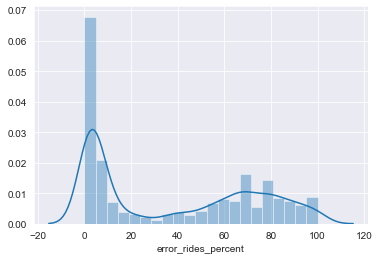

In [62]:
sns.distplot(train_data['error_rides_percent'])

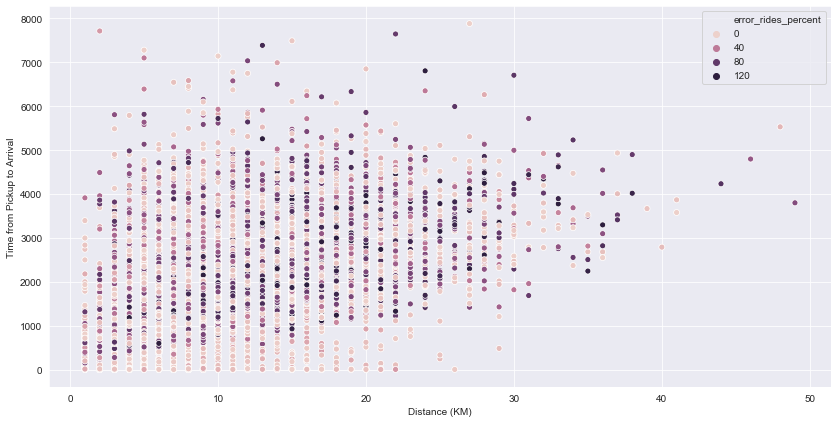

In [63]:
fig = plt.figure(figsize = (14, 7))
sns.scatterplot(data = train_data, x = 'Distance (KM)', y = 'Time from Pickup to Arrival', hue = 'error_rides_percent')

In [64]:
train_data.loc[:, rider_vars].head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_432,1637,1309,13.8,549
1,Rider_Id_856,396,339,13.6,69
2,Rider_Id_155,1023,242,12.5,114
3,Rider_Id_855,886,283,14.5,113
4,Rider_Id_770,2311,872,14.1,533


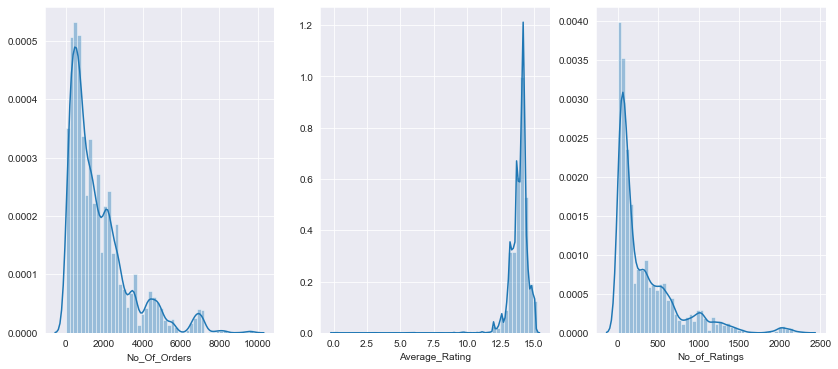

In [65]:
fig, axes = plt.subplots(1, 3, figsize = (14, 6))
sns.distplot(train_data['No_of_Ratings'], ax = axes[2])
sns.distplot(train_data['Average_Rating'], ax = axes[1])
sns.distplot(train_data['No_Of_Orders'], ax = axes[0])

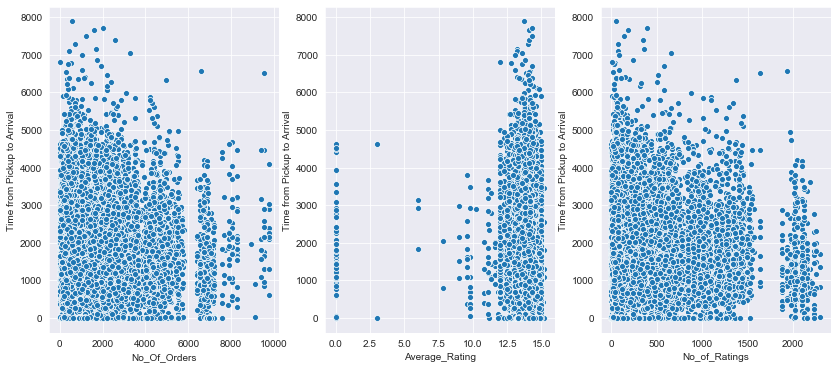

In [66]:
fig, axes = plt.subplots(1, 3, figsize = (14, 6))
sns.scatterplot(data = train_data, x = 'No_Of_Orders', y = 'Time from Pickup to Arrival', ax = axes[0])
sns.scatterplot(data = train_data, x = 'Average_Rating', y = 'Time from Pickup to Arrival', ax = axes[1])
sns.scatterplot(data = train_data, x = 'No_of_Ratings', y = 'Time from Pickup to Arrival', ax = axes[2])

In [67]:
# train_data[train_data['Average_Rating'] == 0][['Average_Rating', 'No_Of_Orders']]

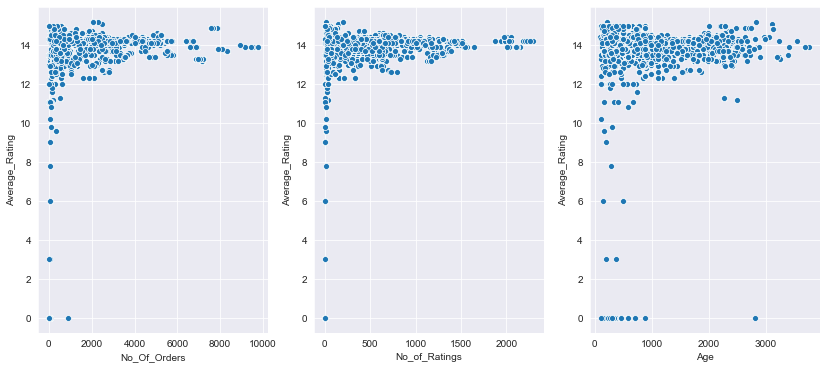

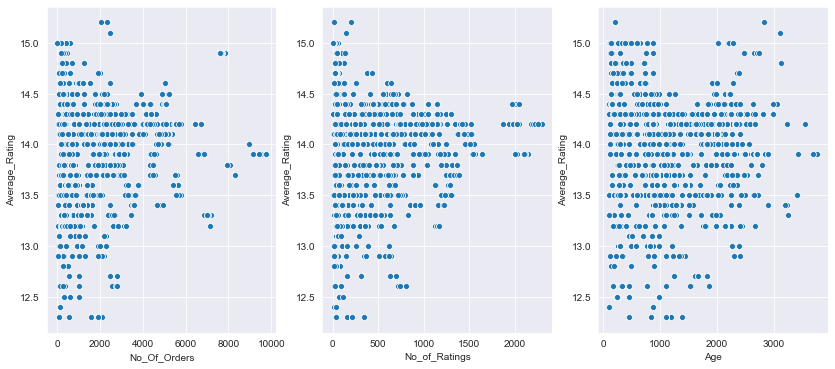

In [68]:
fig, axes = plt.subplots(1, 3, figsize = (14, 6))
sns.scatterplot(data = train_data, x = 'No_Of_Orders', y = 'Average_Rating', ax = axes[0])
sns.scatterplot(data = train_data, x = 'No_of_Ratings', y = 'Average_Rating', ax = axes[1])
sns.scatterplot(data = train_data, x = 'Age', y = 'Average_Rating', ax = axes[2])

mask = train_data['Average_Rating'] > 12
fig, axes = plt.subplots(1, 3, figsize = (14, 6))
sns.scatterplot(data = train_data[mask], x = 'No_Of_Orders', y = 'Average_Rating', ax = axes[0])
sns.scatterplot(data = train_data[mask], x = 'No_of_Ratings', y = 'Average_Rating', ax = axes[1])
sns.scatterplot(data = train_data[mask], x = 'Age', y = 'Average_Rating', ax = axes[2])

count    21201.000000
mean        13.882520
std          0.916071
min          0.000000
25%         13.600000
50%         14.000000
75%         14.300000
max         15.200000
Name: Average_Rating, dtype: float64
count    7174.000000
mean       14.411333
std         0.282040
min        14.100000
25%        14.200000
50%        14.300000
75%        14.600000
max        15.200000
Name: Average_Rating, dtype: float64


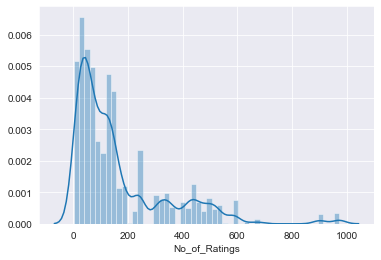

In [69]:
mask1 = train_data['Average_Rating'] > 14
mask2 = train_data['Age'] < 1000
print(train_data['Average_Rating'].describe())
print(train_data['Average_Rating'][mask1 & mask2].describe())
sns.distplot(train_data[mask1 & mask2]['No_of_Ratings'])

Text(0.5, 0, 'Ratio Average Rating / No of Days Since first delivery')

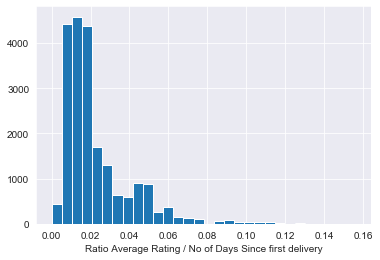

In [70]:
train_data['Average_Rating'].div(train_data['Age']).hist(bins = 30)
plt.xlabel('Ratio Average Rating / No of Days Since first delivery')

In [71]:
train_data['ratio_avg_rating_age'] = train_data['Average_Rating'].div(train_data['Age'])
ratio_rating_age_summary = train_data['ratio_avg_rating_age'].describe()
lower, upper = findBounds(ratio_rating_age_summary)
lower, upper

(-0.04503404555170527, 0.04503404555170527)

In [72]:
mask = train_data['ratio_avg_rating_age'] > upper
hrfr = train_data[mask]['Rider Id'].unique()

In [73]:
high_rating_few_rides_riders = train_data[mask1 & mask2]['Rider Id'].unique()
high_rating_few_rides_riders[:5]

def riderChar(x):
    if x in high_rating_few_rides_riders:
        value = 'excellent'
    else:
        value = 'okay'
    return value
        
train_data['rider_impression'] = train_data['Rider Id'].map(riderChar)

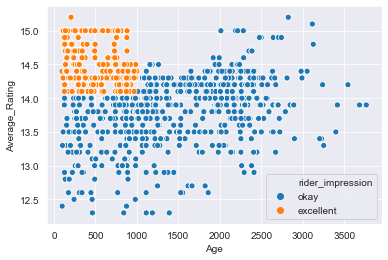

In [74]:
mask = train_data['Average_Rating'] > 12
sns.scatterplot(data = train_data[mask], x = 'Age', y = 'Average_Rating', hue = 'rider_impression')

In [78]:
import feature_engine

ModuleNotFoundError: No module named 'feature_engine'

In [79]:
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder, MeanCategoricalEncoder, RareLabelCategoricalEncoder

ModuleNotFoundError: No module named 'feature_engine'

In [87]:
X = train_data.loc[:, ['Rider Id']]
y = train_data.loc[:, 'Time from Pickup to Arrival']

rare_enc = RareLabelCategoricalEncoder(tol=0.0001, variables=['Rider Id'])
rare_enc.fit(X)
print(rare_enc.transform(X).nunique())

enc = OrdinalCategoricalEncoder(encoding_method='ordered')
enc.fit(X, y)
train_data['rider_id_enc'] = enc.transform(X)['Rider Id']

NameError: name 'RareLabelCategoricalEncoder' is not defined

In [88]:
# fig = plt.figure(figsize = (14, 7))
# sns.barplot(data = train_data, x = 'rider_id_enc', y = 'Time from Pickup to Arrival')

In [89]:
# no_of_orders_in_tr_df = train_data.groupby('Rider Id')[['Rider Id']].count()
train_data.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings', 'Temperature_missing', 'Speed_per_minute',
       'rider_speed', 'rider_avg_speed_per_minute', 'rider_avg_speed',
       'spee

In [90]:
train_data['Temperature'].fillna(np.mean(train_data['Temperature']), inplace = True)

##### Assessing the perfomance of new features

In [91]:
new_vars = ['rider_avg_speed', 'rider_avg_speed_per_minute', 'speed_std',
       'error_rides_percent', 'ratio_avg_rating_age', 'rider_impression', 'rider_id_enc', 'Temperature']

init_predictors = list(set(numeric_vars + geospatial_vars + month_day_vars + week_day_vars + factor_vars + ['Temperature_missing']) - set(missings_vars))

In [92]:
columns_to_remove = [
    'Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
    'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 'Vehicle Type'
]
for column_name in columns_to_remove:
    init_predictors.remove(column_name)
init_predictors, new_vars

(['Temperature_missing',
  'Age',
  'Personal or Business',
  'No_Of_Orders',
  'Destination Long',
  'Pickup Long',
  'No_of_Ratings',
  'Average_Rating',
  'Destination Lat',
  'Pickup - Weekday (Mo = 1)',
  'Pickup - Day of Month',
  'Distance (KM)',
  'Pickup Lat',
  'Platform Type'],
 ['rider_avg_speed',
  'rider_avg_speed_per_minute',
  'speed_std',
  'error_rides_percent',
  'ratio_avg_rating_age',
  'rider_impression',
  'rider_id_enc',
  'Temperature'])

In [93]:
#train_data[new_vars].head()

In [94]:
train_data[init_predictors].head()

,Temperature_missing,Age,Personal or Business,No_Of_Orders,Destination Long,Pickup Long,No_of_Ratings,Average_Rating,Destination Lat,Pickup - Weekday (Mo = 1),Pickup - Day of Month,Distance (KM),Pickup Lat,Platform Type
0,No,1309,Business,1637,36.829741,36.830370,549,13.8,-1.300406,5,9,4,-1.317755,3
1,No,339,Personal,396,36.814358,36.899315,69,13.6,-1.295004,5,12,16,-1.351453,3
2,Yes,242,Business,1023,36.828195,36.843419,114,12.5,-1.300921,2,30,3,-1.308284,3
3,No,283,Business,886,36.795063,36.832396,113,14.5,-1.257147,5,15,9,-1.281301,3
4,No,872,Personal,2311,36.809817,36.792118,533,14.1,-1.295041,1,13,9,-1.266597,1


In [95]:
predictors = {
    'New_features':new_vars,
    'Raw features':init_predictors,
    'All_features':init_predictors + new_vars 
}

In [96]:
def modelEval(estimator, X, y, cv):
    output = pd.DataFrame()
    perfomance = pd.DataFrame()
    variable_importance = pd.DataFrame()

    cv = KFold(n_splits=cv)
    # train_data.loc[:, 'Rider Id']
    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
#         print(i, train_index, test_index)
        X_train = X.loc[train_index, ]
        y_train = y.loc[train_index]
        X_val = X.loc[test_index, ]
        y_val = y.loc[test_index]

        X_train = pd.get_dummies(X_train, drop_first=True)
        X_val = pd.get_dummies(X_val, drop_first=True)

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_val)
        residuals = y_val - y_pred
        data = X_val
        data['Actual'] = y_val
        data['Predictions'] = y_pred
        data['Residuals'] = residuals
        data['FOLD'] = 'Fold_{}'.format(i + 1)
        data['Index'] = test_index
        
#         data = pd.DataFrame({'FOLD': 'Fold_{}'.format(i + 1), 'Index':test_index, 'Predictions': y_pred, 'Actual': y_val, 'Residuals': residuals})
        output = pd.concat([output, data])

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        err_rate = ((rmse / np.mean(y_val)) * 100).round(2)
        results = pd.DataFrame(
            {'FOLD': 'Fold_{}'.format(i + 1), 'RMSE': pd.Series(rmse), 'ERROR_RATE': pd.Series(err_rate)})
        perfomance = pd.concat([perfomance, results])
        
        f_score, p_value = f_regression(X_train, y_train)
        importance = pd.DataFrame({
            'feature':X_train.columns,
            'f_score': f_score,
            'Importance': 1 - p_value
        }
        )
        importance['FOLD'] = 'Fold_{}'.format(i + 1)
        importance = importance.sort_values('Importance', ascending = False).set_index('feature').dropna()
        variable_importance = pd.concat([variable_importance, importance])
        
    return output, perfomance, variable_importance

In [97]:
# 'rider_id_enc' - cross validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

estimators = dict(
    Linear_model = LinearRegression(),
    Lasso_l1 = Lasso(),
    Ridge_l2 = Ridge(),
    Elastic_net = ElasticNet(),
    Decision_tree = DecisionTreeRegressor(criterion='mse'),
    Knn = KNeighborsRegressor(n_neighbors = 20)
)

OUTPUT = {}
PERFOMANCE = {}
VARIABLE_IMPORTANCE = {}

for group, feature_set in predictors.items():
#     print(group, feature_set)
    predictor_set = feature_set

    cv = 10
    X = train_data.loc[:, predictor_set]
    y = train_data.loc[:, 'Time from Pickup to Arrival']

    output = pd.DataFrame()
    perfomance = pd.DataFrame()
    variable_importance = pd.DataFrame()
    for model, estimator in estimators.items():
        out, perf, imp = modelEval(estimator, X, y, cv)
        out['Estimator'] = model
        out['Predictors'] = group
        output = pd.concat([output, out])
        perf['Estimator'] = model
        perf['Predictors'] = group
        perfomance = pd.concat([perfomance, perf])
        imp['Estimator'] = model
        imp['Predictors'] = group
        variable_importance = pd.concat([variable_importance, imp])
    
    OUTPUT[group] = output
    PERFOMANCE[group] = perfomance
    VARIABLE_IMPORTANCE[group] = variable_importance

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [98]:
PERFOMANCE['All_features'].groupby('Estimator').mean()

KeyError: 'All_features'

ValueError: Could not interpret input 'Estimator'

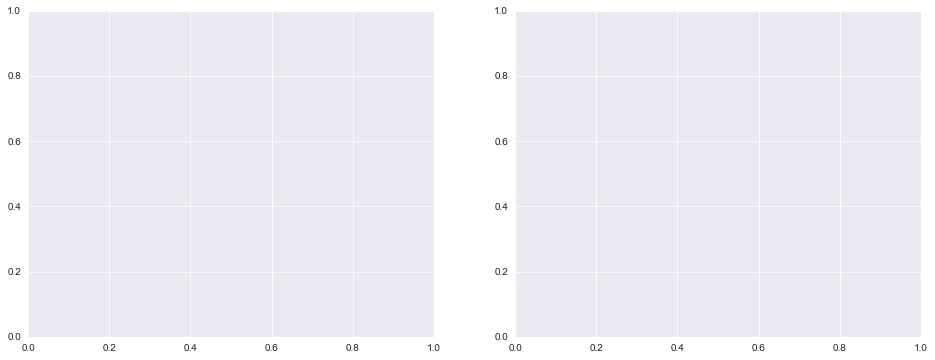

In [99]:
all_data = pd.DataFrame()
for feature_set, data in PERFOMANCE.items():
    feature_set = feature_set
    results = data
    all_data = pd.concat([all_data, data])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.pointplot(data=all_data, x='Estimator', y='RMSE', join=False, ax=axes[0], hue='Predictors')
# plt.title(feature_set)
sns.pointplot(data=all_data, x='Estimator', y='ERROR_RATE', join=False, ax=axes[1], hue='Predictors')
# plt.title(feature_set)

In [100]:
OUTPUT['All_features'].head()

KeyError: 'All_features'

In [101]:
for feature_set, data in OUTPUT.items():
    feature_set = feature_set
    data = OUTPUT[feature_set]
    
    fig, axes = plt.subplots(1, 2, figsize = (20, 4), sharex=False)
    fig = sns.distplot(data['Residuals'], ax = axes[0])
    fig = plt.title(feature_set)
    fig = sns.scatterplot(data = data[data['Estimator'] == 'Linear_model'], x = 'Predictions', y = 'Actual', ax = axes[1])
    fig = plt.xlim(0, 8000)

In [102]:
feature_importance = VARIABLE_IMPORTANCE['All_features'][VARIABLE_IMPORTANCE['All_features']['Estimator'] == 'Linear_model'] \
.reset_index().groupby(['feature']).mean().sort_values('Importance', ascending = False)
imp_vars = feature_importance.index

fig = plt.figure(figsize =(14, 8))
feature_importance['Importance'].plot(kind = 'barh', color = 'teal')
plt.xlabel('Importance')
plt.ylabel(' ')

KeyError: 'All_features'

In [103]:
data = OUTPUT['All_features']
fig, axes = plt.subplots(1, 3, figsize = (20, 6))
sns.scatterplot(data = data[data['Estimator'] == 'Linear_model'], x = 'Average_Rating', y = 'Residuals', ax = axes[1])
sns.scatterplot(data = data[data['Estimator'] == 'Linear_model'], x = 'Distance (KM)', y = 'Residuals', ax = axes[0])
sns.scatterplot(data = data[data['Estimator'] == 'Linear_model'], x = 'rider_id_enc', y = 'Residuals', ax = axes[2])

KeyError: 'All_features'

## Time variables

###### task: check to see if there are orders that are delivered the next day

In [ ]:
placement_not_equal_to_confirmation = train_data['Placement - Day of Month'] != train_data['Confirmation - Day of Month']
confirmation_not_equal_to_pickup = train_data['Confirmation - Day of Month'] != train_data['Arrival at Pickup - Day of Month']
arrival_at_pick_not_equal_to_pickup = train_data['Arrival at Pickup - Day of Month'] != train_data['Pickup - Day of Month']
pickup_not_equal_to_arrival = train_data['Pickup - Day of Month'] != train_data['Arrival at Destination - Day of Month']

mask = placement_not_equal_to_confirmation | confirmation_not_equal_to_pickup | arrival_at_pick_not_equal_to_pickup | pickup_not_equal_to_arrival

train_data[mask][time_vars + ['Time from Pickup to Arrival', 'Rider Id', 'Distance (KM)']]

In [ ]:
datetime_vars = list()
for month_col, time_col in zip(month_day_vars, time_vars):
    new_col_name = '{}'.format(time_col.split('-')[0].replace(' ', ''))
    datetime_vars.append(new_col_name)
    print(new_col_name)
    
    values = list()
    Dates = list()
    for row in train_data.index.values:
        value = '2020' + '-' + '1' + '-' + str(train_data[month_col][row]) 
        values.append(value)
        
        date_string = values[row]
        time_string = train_data[time_col][row]

        Datetime = pd.to_datetime(date_string + ' ' + str(time_string))
#         print(Datetime)
        Dates.append(Datetime)
    train_data[new_col_name] = Dates

train_data.loc[:, datetime_vars].head()

###### task: transform time object to Seconds (to numeric) and visualise them

In [ ]:
iter_dict = {
    'Time from Placement to Confirmation': ['Confirmation', 'Placement'],
    'Time from Confirmation to Arrival at Pickup': ['ArrivalatPickup', 'Confirmation'],
    'Time from Arrival at Pickup to Actual Pickup': ['Pickup', 'ArrivalatPickup'],
    'Time from Placement to Actual Pickup': ['Pickup', 'Placement'],
    'Time from Placement to Arrival at Pickup': ['ArrivalatPickup', 'Placement'],
    'Time from Confirmation to Actual Pickup': ['Pickup', 'Confirmation']
}
numeric_time_vars_sub = list()
for new_column, inputs in iter_dict.items():
    numeric_time_vars_sub.append(new_column)
    col1 = inputs[0]
    col2 = inputs[1]
    train_data[new_column] = train_data[col1] - train_data[col2]
    train_data[new_column] = train_data[new_column].map(lambda timedelt: timedelt.total_seconds())

train_data.loc[:, numeric_time_vars_sub].head()

In [ ]:
train_data.loc[:, numeric_time_vars_sub].describe()

In [ ]:
generateMultiPlot(
    df = train_data,
    variables = numeric_time_vars_sub[0:3] + ['Time from Pickup to Arrival'] + numeric_time_vars_sub[3:],
    nrows = 4,
    ncols = 2,
    length = 12,
    width = 20,
    func = sns.distplot
)

In [ ]:
placement  = train_data['Time from Placement to Confirmation']
train_data[placement < 0][['Time from Placement to Confirmation'] + datetime_vars + month_day_vars].head()

In [ ]:
index_to_replace_w_zero = train_data[placement < 0].index.to_list()
train_data.loc[index_to_replace_w_zero, 'Time from Placement to Confirmation'] = 0

##### Outliers

###### task: detect and treat outliers

In [ ]:
# # user function to fit and train models treated with diffrent outliers methods
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

# def modelEvalOutliers(df, predictors, target, splits, strategy, tail, variables, fold, distribution):

#     RMSE = list()
#     R2_score = list()
#     Error_rate = list()
#     kf = KFold(n_splits=splits, shuffle=True)
#     for train_index, test_index in kf.split(df):

#         train_df = df.loc[train_index, predictors + target]
#         test_df = df.loc[test_index, predictors + target]

#         outlier_treat = strategy(distribution = distribution, tail = tail, variables = variables, fold = fold)
#         outlier_treat.fit(train_df)
#         train_df_treated = outlier_treat.fit_transform(train_df)
        
# #         print('Length of train_df b4 & after:', str(len(train_df.index)), str(len(train_df_treated.index)))
        
#         X_train = train_df_treated.loc[:, predictors]
#         y_train = train_df_treated.loc[:, target]
#         X_val = test_df.loc[:, predictors]
#         y_val = test_df.loc[:, target]

#         regressor = LinearRegression()
#         regressor.fit(X=X_train, y=y_train)
#         y_pred = regressor.predict(X_val)

#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         r_sq = r2_score(y_val, y_pred)
#         error_rate = rmse / np.mean(y_val)                         

#         RMSE.append(rmse)
#         R2_score.append(r_sq)
#         Error_rate.append(error_rate)
#     perfomance = pd.DataFrame({'RMSE': RMSE, 'R2_Score': R2_score, 'Error rate': Error_rate})
    
#     return perfomance

In [ ]:
# from feature_engine.outlier_removers import OutlierTrimmer, Winsorizer

# target = ['Time from Pickup to Arrival']
# predictors = results.index[:9]
# data = train_data.loc[:, predictors + target]

# strategies = {
#     'Trimmer - Mean & Std': [OutlierTrimmer, 'gaussian'],
#     'Trimmer - IQR': [OutlierTrimmer, 'skewed'],
#     'Capping - Mean & Std': [Winsorizer, 'gaussian'],
#     'Capping - IQR': [Winsorizer, 'skewed']
# }

# folds = [0.5, 1, 1.5, 2, 3, 3.5, 4, 4.5, 5]
# perfomance = pd.DataFrame()
# for strategy, elements in strategies.items():
    
# #     print('Strategy:', strategy)
# #     print('class:', elements[0])
# #     print('Distribution:', elements[-1])
#     for fold in folds:
# #         print(fold)

#         model_output = modelEvalOutliers(
#             df = data, 
#             predictors = predictors, 
#             target = target,
#             splits=10,
#             strategy = elements[0],distribution=elements[-1], tail='both', variables=predictors, fold=fold
#         )
        
#         model_output['Fold'] = fold
#         model_output['Strategy'] = strategy

#         perfomance = pd.concat([perfomance, model_output])

In [ ]:
# results = perfomance.groupby(['Strategy', 'Fold']).mean().reset_index()
# results.head()

In [ ]:
# results[results['RMSE'] == results['RMSE'].min()]

In [ ]:
# fig = plt.figure(figsize = (15, 8))
# sns.lineplot(data = results, x = 'Fold', y = 'RMSE', hue='Strategy')
# sns.scatterplot(data = results, x = 'Fold', y = 'RMSE', hue='Strategy', legend = False)

##### Further analysis of Time variables

###### task: extract the AM/PM feature, and visualise

In [ ]:
train_data.loc[:, time_vars].head()

In [ ]:
am_pm_vars = list()
for column_name in time_vars:
    new_column_name = '{}_made_AM/PM'.format(column_name.split('-')[0].replace(' ', ''))
    am_pm_vars.append(new_column_name)
    train_data[new_column_name] = train_data.loc[:, column_name].map(lambda string: string.split()[1])
train_data.loc[:, am_pm_vars].head()

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (16, 6))
for axe, col in zip([0, 1, 2, 3], am_pm_vars):
    sns.boxplot(data = train_data, x = col, y = 'Time from Pickup to Arrival', ax = axes[axe])

###### task: extract the pickup hour and pickup minute and visualise

In [ ]:
train_data.loc[:, datetime_vars].head()

In [ ]:
hour_vars = list()
minute_vars = list()
for col in datetime_vars:
    hours = list()
    minutes = list()
    for order in train_data.index.values:
        hour = train_data.loc[:, col][order].hour
        minute = train_data.loc[:, col][order].minute
        hours.append(hour)
        minutes.append(minute)
#     print(col)
#     print(hours, minutes)
    new_column_name_hour = '{}_hour'.format(col)
    new_column_name_minute = '{}_minute'.format(col)
    hour_vars.append(new_column_name_hour)
    minute_vars.append(new_column_name_minute)
    
    train_data[new_column_name_hour] = hours
    train_data[new_column_name_minute] = minutes
        
train_data.loc[:, hour_vars + minute_vars].head()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (14, 8))
sns.distplot(train_data['Pickup_hour'], ax=axes[0,0])
sns.scatterplot(data=train_data, x= 'Pickup_hour', y='Time from Pickup to Arrival', ax=axes[1,0])

sns.distplot(train_data['Pickup_minute'], ax=axes[0,1])
sns.scatterplot(data=train_data, x= 'Pickup_minute', y='Time from Pickup to Arrival', ax= axes[1,1])

In [ ]:
ind_to_replace = train_data[train_data['Pickup_hour'] ==0].loc[:, 'Pickup_hour'].index

In [ ]:
train_data.loc[ind_to_replace, 'Pickup_hour'] = np.mean(train_data['Pickup_hour'])

###### task: generate interactions between hour and minute, and visualise

In [ ]:
train_data['add_hour_minute'] = train_data['Pickup_minute'].div(60).add(train_data['Pickup_hour'])
train_data['int_hour_minute'] = train_data['Pickup_minute'].div(60).mul(train_data['Pickup_hour'])
fig, axes = plt.subplots(2, 2, figsize = (14, 9))
sns.distplot(train_data['add_hour_minute'], ax=axes[0, 0])
sns.scatterplot(data = train_data, x = 'add_hour_minute', y = 'Time from Pickup to Arrival', ax=axes[1, 0])

sns.distplot(train_data['int_hour_minute'], ax=axes[0, 1])
sns.scatterplot(data = train_data, x = 'int_hour_minute', y = 'Time from Pickup to Arrival', ax=axes[1, 1])

###### task: compute pickup seconds after midnight (time is cyclical afterall) and visualise

In [ ]:
train_data.loc[:, datetime_vars].head()

In [ ]:
def getSecondsPastMidnight(x):
    date = x.date()
    twelve = pd.to_datetime(str(date) + ' ' + '00:00:00 AM')
    diff = x - twelve
    return diff.total_seconds()

train_data['seconds_past_midnight'] = train_data['Pickup'].map(getSecondsPastMidnight)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))
fig = sns.distplot(train_data['seconds_past_midnight'], ax = axes[0])
fig = sns.scatterplot(data = train_data, x = 'seconds_past_midnight', y = 'Time from Pickup to Arrival', ax=axes[1])

In [ ]:
seconds_in_day = 24*60*60

train_data['sin_pickup_time'] = np.sin(2*np.pi*train_data['seconds_past_midnight']/seconds_in_day)
train_data['cos_pickup_time'] = np.cos(2*np.pi*train_data['seconds_past_midnight']/seconds_in_day)

fig, axes = plt.subplots(2, 1, figsize = (18, 6))
fig = train_data['seconds_past_midnight'].plot(ax=axes[0])
fig = train_data['cos_pickup_time'].plot(ax=axes[1])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.scatterplot(data = train_data, x = 'sin_pickup_time', y = 'Time from Pickup to Arrival', ax=axes[0])
sns.scatterplot(data = train_data, x = 'cos_pickup_time', y = 'Time from Pickup to Arrival', ax=axes[1])

In [ ]:
train_data.plot.scatter('sin_pickup_time','cos_pickup_time').set_aspect('equal')

##### Discretisation

###### task: write function to descritise data and another to visualise the descrited features

In [ ]:
from feature_engine.discretisers import EqualWidthDiscretiser, EqualFrequencyDiscretiser
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

def applyDescritiser(X, y, discritiser, bins, variables):
    disc = discritiser(bins, variables = variables, return_object=True)
    disc.fit(X)
    X_discr = disc.transform(X)

    enc = OrdinalCategoricalEncoder(encoding_method='ordered')
    enc.fit(X_discr, y)
    return enc.transform(X_discr)

def plotBins(df, variable):
    comb_data = train_data.copy()
    comb_data['bins'] = df[variable].astype('category')
    comb_data['Time from Pickup to Arrival'] = y

    fig, axes = plt.subplots(1, 2, figsize = (14, 5))
    fig = sns.barplot(data = comb_data, x = 'bins', y = 'Time from Pickup to Arrival', ax=axes[1])
    fig = sns.lineplot(data = comb_data, x = 'bins', y = 'Time from Pickup to Arrival', ax=axes[1])

    fig = sns.scatterplot(data=comb_data, x= variable, y='Time from Pickup to Arrival', ax=axes[0], hue='bins', legend = False)
    return fig

###### task: implement unsupervised binning techniques and analyse

In [ ]:
X = train_data.loc[:, predictors['All_features'] + ['Pickup_hour', 'add_hour_minute']]
y = train_data['Time from Pickup to Arrival']
X

In [ ]:
X_ew_discr = applyDescritiser(X, y,
    discritiser=EqualWidthDiscretiser, bins = 6, variables=['Pickup_hour', 'add_hour_minute']
)
X_ef_discr = applyDescritiser(X, y,
    discritiser=EqualFrequencyDiscretiser, bins = 6, variables=['Pickup_hour', 'add_hour_minute']
)

In [ ]:
X_ew_discr.head()

In [ ]:
plotBins(X_ef_discr, 'Pickup_hour')
plt.title('Equal width bins')
plotBins(X_ef_discr, 'add_hour_minute')
plt.title('Equal frequency bins')

###### task: implement supervised binning techniques and analyse

In [ ]:
from feature_engine.discretisers import DecisionTreeDiscretiser
DT_disc = DecisionTreeDiscretiser(
                        cv=10,
                        scoring='neg_root_mean_squared_error',
                        variables=['Pickup_hour', 'add_hour_minute'],
                        regression=True,
                        param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 10],
                                    'min_samples_leaf': [10, 4, 2, 1]},
                        random_state=1)
X = train_data.loc[:, ['Pickup_hour', 'add_hour_minute']]
y = train_data.loc[:, 'Time from Pickup to Arrival']
DT_disc.fit(X, y)
DT_discr = DT_disc.transform(X)

In [ ]:
DT_discr.head()

In [ ]:
add_hm_bins = list(DT_discr['add_hour_minute'].unique())
pickup_hour_bins = list(DT_discr['Pickup_hour'].unique())

In [ ]:
def convertBinsToCategory(df, feature, bins):
    bins = pd.Series(bins).sort_values()
    df[feature] = np.where(
        df[feature] == bins[0], 'Bin_1', np.where(
            df[feature] == bins[1], 'Bin_2', np.where(
                df[feature] == bins[2], 'Bin_3', np.where(
                    df[feature] == bins[3], 'Bin_4', DT_discr[feature]
                )
            )
        )
    )
    return df

In [ ]:
convertBinsToCategory(df = DT_discr, feature = 'Pickup_hour', bins = pickup_hour_bins)
convertBinsToCategory(df = DT_discr, feature = 'add_hour_minute', bins = add_hm_bins)

plotBins(DT_discr, 'Pickup_hour')
plotBins(DT_discr, 'add_hour_minute')

##### Weekday and Monthday variables

###### task: get days of the week for weekdays

In [ ]:
train_data.loc[:, week_day_vars + month_day_vars].head()

In [ ]:
train_data['Pickup_weekday'] = np.where(train_data['Pickup - Weekday (Mo = 1)'] == 1, 'Monday',
                                        np.where(train_data['Pickup - Weekday (Mo = 1)'] == 2, 'Tuesday',
                                                 np.where(train_data['Pickup - Weekday (Mo = 1)'] == 3, 'Wednesday',
                                                          np.where(train_data['Pickup - Weekday (Mo = 1)'] == 4, 'Thursday',
                                                                   np.where(train_data['Pickup - Weekday (Mo = 1)'] == 5, 'Friday',
                                                                            np.where(train_data['Pickup - Weekday (Mo = 1)'] == 6, 'Saturday',
                                                                                     np.where(train_data['Pickup - Weekday (Mo = 1)'] == 7, 'Sunday', train_data['Pickup - Weekday (Mo = 1)']
                                                                                              )
                                                                                     )
                                                                            )
                                                                   )
                                                          )
                                                 )
                                        )
train_data['is_weekend'] = np.where(train_data['Pickup_weekday'] == 'Saturday', 'Weekend',
                                    np.where(
                                        train_data['Pickup_weekday'] == 'Sunday', 'Weekend', 'Weekeday')
                                    )

###### task: apply ordeinal encording to weekdays and visualise

In [81]:
enc = OrdinalCategoricalEncoder(encoding_method='ordered')
X = train_data[['Pickup_weekday']]
y = train_data['Time from Pickup to Arrival']
enc.fit(X, y)
train_data['Pickup_weekday_ordered'] = enc.transform(X)['Pickup_weekday']
enc.encoder_dict_

NameError: name 'OrdinalCategoricalEncoder' is not defined

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
sns.lineplot(data = train_data, x = 'Pickup_weekday_ordered', y = 'Time from Pickup to Arrival', ax=axes[0]
)
sns.countplot(data = train_data, x = 'Pickup_weekday_ordered', ax=axes[1]
)

###### task: evaluate the efficacy of the is_weekday feature

In [ ]:
g = sns.FacetGrid(data = train_data, col = 'is_weekend')
g.map(sns.scatterplot, 'Pickup_hour', 'Time from Pickup to Arrival', color = 'teal')

##### Assessing the perfomance of models

###### task: assess the perfomance of discretisation

In [ ]:
new_time_vars = [
       'Time from Placement to Confirmation',
       'Time from Confirmation to Arrival at Pickup',
       'Time from Arrival at Pickup to Actual Pickup',
       'Time from Placement to Actual Pickup',
       'Time from Placement to Arrival at Pickup',
       'Time from Confirmation to Actual Pickup', 'Placement_made_AM/PM',
       'Confirmation_made_AM/PM', 'ArrivalatPickup_made_AM/PM',
       'Pickup_made_AM/PM', 'Placement_hour', 'Placement_minute',
       'Confirmation_hour', 'Confirmation_minute', 'ArrivalatPickup_hour',
       'ArrivalatPickup_minute', 'Pickup_hour', 'Pickup_minute',
       'add_hour_minute', 'int_hour_minute', 'seconds_past_midnight',
       'sin_pickup_time', 'cos_pickup_time', 'Pickup_weekday', 'is_weekend',
       'Pickup_weekday_ordered'
]
new_time_vars

In [ ]:
X = train_data.loc[:, predictors[:-1]]
y = train_data['Time from Pickup to Arrival']

#####################################################################

def modelEvalDiscretisation(strategy, bins, variables, model):
    RMSE = list()
    R2_score = list()
    Error_rate = list()

    cv = KFold(n_splits=10, shuffle=True, random_state=111)
    for train_index, test_index in cv.split(X):
        X_train = X.loc[train_index, ]
        y_train = y[train_index]
        X_val = X.loc[test_index, ]
        y_val = y[test_index]

        disc = strategy(bins, variables = variables, return_object=True)
        disc.fit(X_train)
        X_train_trans = disc.transform(X_train)
        X_val_trans = disc.transform(X_val)

        enc = OrdinalCategoricalEncoder(encoding_method='ordered')
        enc.fit(X_train_trans, y)
        X_train['Pickup_hour_bins'] = enc.transform(X_train_trans)['Pickup_hour']
        X_val['Pickup_hour_bins'] = enc.transform(X_val_trans)['Pickup_hour']
        
        X_train.pop('Pickup_hour')
        X_val.pop('Pickup_hour')
        
        regressor = model()
        regressor.fit(X=X_train, y=y_train)
        y_pred = regressor.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r_sq = r2_score(y_val, y_pred)
        error_rate = rmse / np.mean(y_val)

        RMSE.append(rmse)
        R2_score.append(r_sq)
        Error_rate.append(error_rate)
        perfomance = pd.DataFrame(
            {'RMSE': RMSE, 'R2_Score': R2_score, 'Error rate': Error_rate}
        )
    return perfomance

In [ ]:
strategies = {
    'Equal Width Discretiser': {'descritiser': EqualWidthDiscretiser, 'bins': [3, 4, 5, 6, 7, 8], 'models': [LinearRegression]},
    'Equal Frequency Discretiser': {'descritiser': EqualFrequencyDiscretiser, 'bins': [3, 4, 5, 6, 7, 8], 'models': [LinearRegression]}
}

perfomance = pd.DataFrame()

for strategy, elements in strategies.items():
    print(strategy, elements['descritiser'], elements['bins'], elements['models'])
    
    for interval in elements['bins']:
        for model in elements['models']:
            output = modelEvalDiscretisation(
                strategy = elements['descritiser'],
                bins = interval,
                variables = ['Pickup_hour'],
                model = model
            ) 
            output['Strategy'] = strategy
            output['bins'] = interval
            perfomance = pd.concat([perfomance, output])

In [ ]:
perfomance.groupby(['Strategy', 'bins']).mean()

In [ ]:
predictors

In [ ]:
cv = KFold(n_splits=10)

X = train_data.loc[:, predictors[:-1]]
y = train_data.loc[:, 'Time from Pickup to Arrival']

RMSE = list()
R2_score = list()
Error_rate = list()

for train_index, test_index in cv.split(X, y):
    X_train = X.loc[train_index, ]
    y_train = y[train_index]
    X_val = X.loc[test_index, ]
    y_val = y[test_index]

    disc = DecisionTreeDiscretiser(
        cv=10,
        scoring='neg_root_mean_squared_error',
        variables=['Pickup_hour'],
        regression=True,
        param_grid={'max_depth': [1, 2, 3],
                    'min_samples_leaf': [10, 4]},
        random_state=1)

    disc.fit(X_train, y_train)
    X_train_trans = disc.transform(X_train)
    X_val_trans = disc.transform(X_val)

    regressor = LinearRegression()
    regressor.fit(X_train_trans, y_train)
    y_pred = regressor.predict(X_val_trans)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r_sq = r2_score(y_val, y_pred)
    error_rate = rmse / np.mean(y_val)

    RMSE.append(rmse)
    R2_score.append(r_sq)
    Error_rate.append(error_rate)
    perfomance = pd.DataFrame(
        {'RMSE': RMSE, 'R2_Score': R2_score, 'Error rate': Error_rate}
    )

In [ ]:
perfomance.mean()

## Geospatial variables

## Factor variables

###### task: plot barchars for factors
When generating barchars for factor variables we look out for features with too many categories that can be grouped together. The grouping can depend on how the different levels relate to the target variable. For example if there is inherent ordering of the levels with the target fewer categories can be created by grouping based on a scale of low, medium and high values of the target. This is called mean target encoding and is an option we may look into for feature with too many level like day of the month (usually 30 levels).

In [ ]:
train_data.loc[:, factor_vars].describe()

In [ ]:
# generateMultiPlot(
#     df = train_data,
#     variables = factor_vars,
#     nrows = 3,
#     ncols = 1,
#     length = 18,
#     width = 20,
#     func = sns.countplot
# )

# Multivariate Analysis

**Numerical Variables**

In [ ]:
# analyse relationships between features (correlation and factor analysis)
# analyse relationships between features (correlation and factor analysis)
#g=sns.pairplot(train_data[['No_Of_Orders', 'Age', 'Average_Rating','Distance (KM)','Temperature','No_of_Ratings','Time from Pickup to Arrival']])
#g.fig.set_size_inches(9,9)

In [ ]:
# check for collinearity and multi-collinearity

In [ ]:
from statsmodels.graphics.correlation import plot_corr

fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(111);
plot_corr(train_data.corr(), xnames = train_data.corr().columns, ax = ax);

In [ ]:
# All days of the months variables are highly correlated
# All days of the week variables are highly correlated correlated
#rider average speed and speed standard deviation are aslo correlated
#Error rides percent and speed std are coorelated
#number of orders is correlated with both Number of ratings and age


In [ ]:
# analyses relationship between features and target

**Catergorical variables**

In [ ]:
grid = sns.FacetGrid(train_data, row='Platform Type', col='Personal or Business', height=2.0, aspect=3.0)
grid.map(plt.hist,'Time from Pickup to Arrival', bins=30)
grid.add_legend()
plt.show()

# Feature Engineering

In [ ]:
# investigate non linearity


In [ ]:
# investigate feature interactions and synergy


In [83]:
# other transformations (data mining)
#Feature scalling 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = train_data_transf.loc[:, predictors[:-1]]
y = train_data_transf.loc[:, 'Time from Pickup to Arrival']

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

sc_x= StandardScaler()
sc_y= StandardScaler()
X_train_scaled=sc_x.fit_transform(X_train)

y_train_scaled=sc_y.fit_transform(y_train)
X_test_scaled=sc_x.transform(X_test)


ValueError: could not convert string to float: 'Bike'

# Feature Selection

In [ ]:
# L2 Regularisation - Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso


ridge = Ridge()
ridge.fit(X_train_scaled, y_train_scaled)
y_ridge =sc_y.inverse_transform(ridge.predict(X_test_scaled))

rmse = np.sqrt(mean_squared_error(y_val, y_ridge))
r_sq = r2_score(y_val, y_ridge)
error_rate = rmse / np.mean(y_val)

RMSE.append(rmse)
R2_score.append(r_sq)
Error_rate.append(error_rate)
perfomance = pd.DataFrame(
{'RMSE': RMSE, 'R2_Score': R2_score, 'Error rate': Error_rate}

In [ ]:
# L1 Regularisation -Lasso
lasso = Lasso()
lasso.fit(X_train_scaled, y_train)
y_lasso =sc_y.inverse_transform(lasso.predict(X_train_scaled))

rmse = np.sqrt(mean_squared_error(y_val, y_lasso))
r_sq = r2_score(y_val, y_lasso)
error_rate = rmse / np.mean(y_val)

RMSE.append(rmse)
R2_score.append(r_sq)
Error_rate.append(error_rate)
perfomance = pd.DataFrame(
{'RMSE': RMSE, 'R2_Score': R2_score, 'Error rate': Error_rate}
    

In [ ]:
# forward selection, backward selection and/or mixed selection

In [ ]:
# genetic algorithms (borita)

# Ensembled methods

In [ ]:
# Random forests and feature importance
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 150, random_state = 0)
regressor.fit(x_train, y_train)
yrd_pred = regressor.predict(x_test)
r2_score(y_test, yrd_pred)

RMSE_rf_test= np.sqrt( mean_squared_error(y_test, yrd_pred))
RMSE_rf_train= np.sqrt( mean_squared_error(y_train, regressor.predict(x_train)))





# Model Selection 

In [ ]:
# fit multiple models and do hyper-parameter tuning

In [ ]:
# cross validate model perfomance

In [ ]:
# select the best model and implement it as final solution

# Summary of Conclusions

In [ ]:
# summarise findings and make recommendations